In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [2]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()

In [3]:
for i in range(classes):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((32,32))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

In [4]:
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

(39209, 32, 32, 3) (39209,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)


In [6]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [7]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (32,32,3))
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(43, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')

In [11]:
n_epochs = 50
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1, 
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/50
981/981 [==============================] - 93s 77ms/step - loss: 4.2162 - accuracy: 0.1555 - val_loss: 121.6186 - val_accuracy: 0.0339


C:\Users\Suhan Gautam\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
981/981 [==============================] - 72s 73ms/step - loss: 3.5717 - accuracy: 0.2021 - val_loss: 2.9053 - val_accuracy: 0.2276
Epoch 3/50
981/981 [==============================] - 71s 73ms/step - loss: 3.7227 - accuracy: 0.1697 - val_loss: 16.3760 - val_accuracy: 0.0240
Epoch 4/50
981/981 [==============================] - 70s 71ms/step - loss: 3.7064 - accuracy: 0.1259 - val_loss: 5.9968 - val_accuracy: 0.2165
Epoch 5/50
981/981 [==============================] - 71s 72ms/step - loss: 2.2906 - accuracy: 0.3782 - val_loss: 1.5884 - val_accuracy: 0.4694
Epoch 6/50
981/981 [==============================] - 70s 71ms/step - loss: 2.1274 - accuracy: 0.4341 - val_loss: 3.3710 - val_accuracy: 0.2456
Epoch 7/50
981/981 [==============================] - 70s 71ms/step - loss: 1.7124 - accuracy: 0.5016 - val_loss: 3.6667 - val_accuracy: 0.1695
Epoch 8/50
981/981 [==============================] - 70s 71ms/step - loss: 1.2720 - accuracy: 0.6160 - val_loss: 0.7542 - val_accuracy

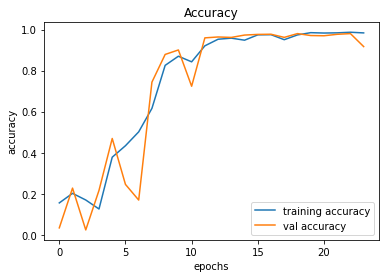

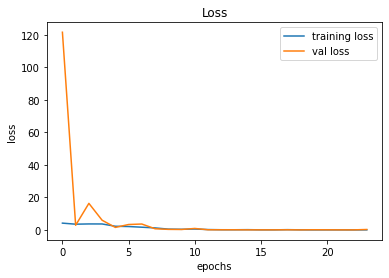

In [12]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('Test.csv')
labels = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]
for img in imgs:
    image = Image.open(img)
    image = image.resize((32,32))
    data.append(np.array(image))
X_test=np.array(data)
predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[16  1 38 ...  5  7 10]


In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(labels,classes_x))
model.save("ninetyfive.h5")

0.9247822644497229


C:\Users\Suhan Gautam\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
